In [2]:
library(tidytext)
library(stringr)
library(tidyverse)
library(tibble)
library(ggplot2)
library(lubridate)
library(SnowballC)
library(RSQLite)
library(sparklyr)
library(wordcloud)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.0.0     ✔ readr   1.1.1
✔ tibble  1.4.2     ✔ purrr   0.2.5
✔ tidyr   0.8.1     ✔ dplyr   0.7.6
✔ ggplot2 3.0.0     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘lubridate’

The following object is masked from ‘package:base’:

    date


Attaching package: ‘sparklyr’

The following object is masked from ‘package:purrr’:

    invoke

Loading required package: RColorBrewer


In [3]:
# Set memory allocation for whole local Spark instance
Sys.setenv("SPARK_MEM" = "8G")

# Set driver and executor memory allocations
config <- spark_config()
config$spark.driver.memory <- "4G"
config$spark.executor.memory <- "1G"
config$`sparklyr.shell.driver-memory` <- "4G"
config$`sparklyr.shell.executor-memory` <- "4G"
config$`spark.yarn.executor.memoryOverhead` <- "1g"

sc <- spark_connect(master = "local", config = config)

In [4]:
tweets_bitcoin_df <- spark_read_csv(sc, name = "bitcoin", '/home/apcloud44/latent_aspect_modeling/data/bitcoinoct17tooct18/all_sorted.csv')
tweets_eth_df <- spark_read_csv(sc, name = "eth", '../../data/eth_1aug15_1aug18/0.csv')
tweets_facebook_df <- spark_read_csv(sc, name = "facebook", '../../data/facebook3March18to1Sep18/0.csv')

In [5]:
head(tweets_bitcoin_df)

# Source:   lazy query [?? x 23]
# Database: spark_connection
  Tweet_ID Conversation_ID Author_Id Author_Name isVerified DateTime Language
     <dbl>           <dbl>     <dbl> <chr>            <int> <chr>    <chr>   
1  9.62e17         9.62e17   9.04e17 CryptoCoin…          0 2018-02… bg      
2  9.62e17         9.62e17   9.04e17 CryptoCoin…          0 2018-02… bg      
3  9.62e17         9.62e17   8.82e17 NowBitcoin…          0 2018-02… ca      
4  9.62e17         9.62e17   8.94e17 falileevam4          0 2018-02… de      
5  9.62e17         9.62e17   9.55e17 cryptoaudio          0 2018-02… en      
6  9.62e17         9.62e17   9.59e17 ADATicker            0 2018-02… en      
# ... with 16 more variables: Tweet_Text <chr>, Replies <int>, Retweets <int>,
#   Favorites <int>, Mentions <chr>, Hashtags <chr>, Permalink <chr>,
#   URLs <chr>, isPartOfConversation <chr>, isReply <chr>, isRetweet <chr>,
#   Reply_To_User_ID <chr>, Reply_To_User_Name <chr>, Quoted_Tweet_ID <chr>,
#   Quoted_T

In [6]:
head(tweets_eth_df)

# Source:   lazy query [?? x 22]
# Database: spark_connection
  TweetID ConversationID AuthorId AuthorName isVerified DateTime TweetText
    <dbl>          <dbl>    <dbl> <chr>           <int> <chr>    <chr>    
1 1.02e18        1.02e18  2.28e 9 coinspect…          0 2018-07… Shopin C…
2 1.02e18        1.02e18  9.64e17 drewawise           1 2018-07… You must…
3 1.02e18        1.02e18  2.60e 8 BeerdHead           0 2018-07… Dear all…
4 1.02e18        1.02e18  4.61e 7 maransa20…          0 2018-07… "This tw…
5 1.02e18        1.02e18  9.53e17 CereloMas…          0 2018-07… CYDER To…
6 1.02e18        1.02e18  6.05e 8 defri_dodi          0 2018-07… Trying t…
# ... with 15 more variables: Replies <int>, Retweets <int>, Favorites <int>,
#   Mentions <chr>, Hashtags <chr>, Permalink <chr>, URLs <chr>,
#   isPartOfConversation <chr>, isReply <chr>, isRetweet <chr>,
#   ReplyToUserID <chr>, ReplyToUserName <chr>, QuotedTweetID <chr>,
#   QuotedTweetUserName <chr>, QuotedTweetUserID <chr>

In [7]:
head(tweets_facebook_df)

# Source:   lazy query [?? x 22]
# Database: spark_connection
  TweetID ConversationID AuthorId Author_Name isVerified DateTime TweetText
    <dbl>          <dbl>    <dbl> <chr>            <int> <chr>    <chr>    
1 1.04e18        1.04e18  3.22e 8 RipoffRepo…          0 2018-08… IT MAY N…
2 1.04e18        1.04e18  1.85e 9 kris_jayne           0 2018-08… ★★LABOR …
3 1.04e18        1.04e18  1.14e 9 roneebsas            0 2018-08… << ¡Nos …
4 1.04e18        1.04e18  2.79e 9 mostwatche…          0 2018-08… Zion & #…
5 1.04e18        1.04e18  1.00e18 NortonCust…          1 2018-08… #Faceboo…
6 1.04e18        1.04e18  1.00e18 NortonCust…          1 2018-08… #Faceboo…
# ... with 15 more variables: Replies <int>, Retweets <int>, Favorites <int>,
#   Mentions <chr>, Hashtags <chr>, Permalink <chr>, URLs <chr>,
#   isPartOfConversation <chr>, isReply <chr>, isRetweet <chr>,
#   ReplyToUserID <chr>, ReplyToUserName <chr>, QuotedTweetID <chr>,
#   QuotedTweetUserName <chr>, QuotedTweetUserID <chr>

In [8]:
tweets_df <- tweets_bitcoin_df %>% mutate(ds = 'bitcoin') 

#%>%
#                sdf_bind_rows(tweets_eth_df %>% mutate(ds = 'eth')) %>%
#                sdf_bind_rows(tweets_facebook_df %>% mutate(ds = 'facebook'))
                

In [9]:
tweets_df <- tweets_df %>%
  mutate(line = regexp_replace(Tweet_Text, "[_\"\'():;,.!?\\-]", " ")) 

In [10]:
tidy_tweets <- tweets_df %>% compute('tidy_tweets')

In [11]:
tweets_df <- tweets_df %>%
 select(Tweet_ID, Tweet_Text, ds) %>%
    ft_tokenizer(input.col = "Tweet_Text",
               output.col = "word_list") 

head(tweets_df)

# Source:   lazy query [?? x 4]
# Database: spark_connection
  Tweet_ID Tweet_Text                                         ds     word_list 
     <dbl> <chr>                                              <chr>  <list>    
1  9.62e17 Арбитражни операции с криптоактивами. Част 2 - Кр… bitco… <list [14…
2  9.62e17 Технически работата на борсата Binance удължава д… bitco… <list [16…
3  9.62e17 Feb 09; 2018 00:00:00 UTC | 8;237.20$ | 6;725.10€… bitco… <list [14…
4  9.62e17 @forex @btc @fx #bitcoin KUANGCHENG ANT MINER R1 … bitco… <list [20…
5  9.62e17 "\"Tezos Has a New Board; But What Does It Mean f… bitco… <list [33…
6  9.62e17 #ADA Price is 0.00004333 (+0.00000002) #BTC / 0.3… bitco… <list [17…

In [12]:
tidy_tweets <- tweets_df %>% compute('tidy_tweets')

In [13]:
tweets_df <- tweets_df %>%
  ft_stop_words_remover(input.col = "word_list",
                        output.col = "wo_stop_words")

head(tweets_df, 4)

# Source:   lazy query [?? x 5]
# Database: spark_connection
  Tweet_ID Tweet_Text                            ds     word_list wo_stop_words
     <dbl> <chr>                                 <chr>  <list>    <list>       
1  9.62e17 Арбитражни операции с криптоактивами… bitco… <list [1… <list [14]>  
2  9.62e17 Технически работата на борсата Binan… bitco… <list [1… <list [16]>  
3  9.62e17 Feb 09; 2018 00:00:00 UTC | 8;237.20… bitco… <list [1… <list [14]>  
4  9.62e17 @forex @btc @fx #bitcoin KUANGCHENG … bitco… <list [2… <list [19]>  

In [14]:
tweets_df <- tweets_df %>%
  mutate(word = explode(wo_stop_words)) %>%
  select(word, ds, Tweet_ID) %>%
  filter(nchar(word) > 2)
  
head(tweets_df, 4)

# Source:   lazy query [?? x 3]
# Database: spark_connection
  word            ds      Tweet_ID
  <chr>           <chr>      <dbl>
1 арбитражни      bitcoin  9.62e17
2 операции        bitcoin  9.62e17
3 криптоактивами. bitcoin  9.62e17
4 част            bitcoin  9.62e17

In [15]:
tidy_tweets <- tweets_df %>% compute('tidy_tweets')

In [16]:
head(tidy_tweets)

# Source:   lazy query [?? x 3]
# Database: spark_connection
  word                                                          ds     Tweet_ID
  <chr>                                                         <chr>     <dbl>
1 арбитражни                                                    bitco…  9.62e17
2 операции                                                      bitco…  9.62e17
3 криптоактивами.                                               bitco…  9.62e17
4 част                                                          bitco…  9.62e17
5 криптовалута                                                  bitco…  9.62e17
6 http://cryptocoinportal.life/news/arbitrajni-operacii-s-krip… bitco…  9.62e17

In [17]:
tidy_tweets_count <- tidy_tweets %>%
  group_by(ds, word) %>%
  tally() %>%
  arrange(desc(n)) 
  
tidy_tweets_count

# Source:     lazy query [?? x 3]
# Database:   spark_connection
# Groups:     ds
# Ordered by: desc(n)
   ds      word                  n
   <chr>   <chr>             <dbl>
 1 bitcoin #bitcoin        2976691
 2 bitcoin #blockchain      933010
 3 bitcoin #cryptocurrency  853024
 4 bitcoin #crypto          843246
 5 bitcoin #ethereum        759721
 6 bitcoin #btc             648116
 7 bitcoin #ico             488789
 8 bitcoin bitcoin          351342
 9 bitcoin btc              349905
10 bitcoin #eth             326654
# ... with more rows

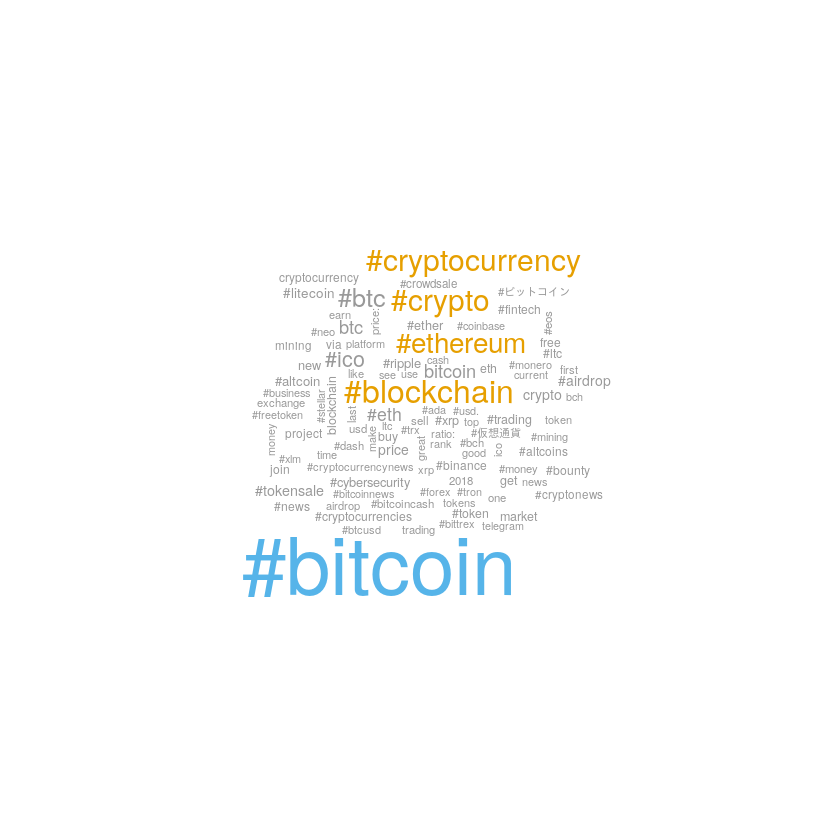

In [20]:
tidy_tweets_count %>%
    head(100) %>%
  collect() %>% # It's better to collect less data to avoid memory issues.
  with(wordcloud::wordcloud(
    word, 
    n,
    colors = c("#999999", "#E69F00", "#56B4E9","#56B4E9")))